# Training notebook

* This notebook is used for building, training and evaluating CNN models on MURA dataset.  
* For the purpose of experimentation, the CNN model, dataset type (original / preprocessed offline), online augmentation and preprocessing can be easily changed with the use of custom functions
* More information on used functions can be found mainly in python files ***utils.py*** and ***image_preprocessing.py***
* Some cells are specific for Google Colab environment and might not work correctly in other environments

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
import pandas as pd
import pickle
import numpy as np
import cv2
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import matplotlib.pyplot as plt
%matplotlib inline

# Google Colab does not have tensorflow_addons installed by default
!pip install tensorflow-addons
from tensorflow_addons.metrics import CohenKappa

     |████████████████████████████████| 1.1 MB 5.1 MB/s 


# CONSTANTS 

In [15]:
# FILEPATHS
DRIVE_DIR = '/content/drive/MyDrive/MURA/' # Directory in my personal Google Drive with all source files and datasets
MURA_DIR = '/content/datasets/original/' # Directory with original MURA dataset
CLAHE_2_DIR = '/content/datasets/clahe_2/' # Directory for CLAHE preprocessed dataset with clipLimit=2
CLAHE_10_DIR = '/content/datasets/clahe_10/' # Directory for CLAHE preprocessed dataset with clipLimit=10
DATAFRAME_PATH = '/content/datasets/tvt_detailed_paths.csv' # Path to csv file with dataset information (train-valid-test split)
CHECKPOINT_DIR = '/content/drive/MyDrive/MURA/models/' # Root directory for storing models

# DATAFRAME FLOW
BATCH_SIZE = 32
# MODEL
BASE_NAME = 'ResNet50'
WEIGHTS = 'imagenet'
INPUT_SHAPE = (224, 224, 3)
POOLING = 'avg'
MODEL_NAME = BASE_NAME + '_' + POOLING + '_imagenet'
# TRAINING
EPOCHS = 10

# Google Colab specific section

## Mount Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Google colab functions

Next cell containts function definitions, that are needed or useful when running notebook in Google Colab, such as copying dataset from Google Drive, checking GPU utilization, copying other files from Google Drive.

In [4]:
# This function is from Google Colab guide notebooks: https://colab.research.google.com/notebooks/pro.ipynb
def check_gpu():
  """
  Prints information about available GPU or message saying there isn't one
  """
  gpu_info = !nvidia-smi
  gpu_info = '\n'.join(gpu_info)
  if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
  else:
    print(gpu_info)


def init_file_struct():
  """
  Prep file structure in Google Colab and copies neccessary files from Google Drive
  """
  !mkdir datasets
  !cp "{DRIVE_DIR}src/utils.py" .
  !cp "{DRIVE_DIR}src/image_preprocessing.py" .


def copy_dataset(filename):
  """
  Copies and unzips dataset from Google Drive and deletes the zipped file

  Parameters
  ----------
  filename : str
    Dataset filename, without its path, the path will be added from constants
  """
  !cp {DRIVE_DIR}{filename} /content/datasets/

  !unzip -q /content/datasets/{filename}

  !rm /content/datasets/{filename}

## Import python files after copying them from Google Colab

In [5]:
init_file_struct()
from utils import *
from image_preprocessing import *

## Copy desired dataset to be used

In [6]:
copy_dataset('clahe_2.zip')

# Create datagens and flow

In [10]:
train_df = get_dataframe(body_part='SHOULDER', split='train', path=DATAFRAME_PATH)
valid_df = get_dataframe(body_part='SHOULDER', split='valid', path=DATAFRAME_PATH)

train_gen, valid_gen = create_generators(pre_func=rescale) 

train_flow, valid_flow = create_dataframe_flows(train_gen=train_gen,
                                                valid_gen=valid_gen,
                                                train_df=train_df,
                                                valid_df=valid_df,
                                                directory=CLAHE_2_DIR,
                                                batch_size=BATCH_SIZE)

Found 8257 validated image filenames belonging to 2 classes.
Found 563 validated image filenames belonging to 2 classes.


# Build model

In [16]:
model = build_model(base_name=BASE_NAME,
                    weights=WEIGHTS, 
                    shape=INPUT_SHAPE,
                    pooling=POOLING,
                    name=MODEL_NAME)

In [17]:
model.summary()

Model: "ResNet50_avg_imagenet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                              

In [ ]:
best_path = CHECKPOINT_DIR + MODEL_NAME + '_best.h5'
# last_path = CHECKPOINT_DIR + MODEL_NAME + '_last.h5'

checkpoint_best = ModelCheckpoint(filepath=best_path,
                                  save_weights_only=True,
                                  monitor='val_kappa',
                                  mode='max',
                                  save_best_only=True,
                                  verbose=1)

# checkpoint_last = ModelCheckpoint(filepath=last_path,
#                                   save_weights_only=True,
#                                   verbose=0)

early_stop = EarlyStopping(monitor='val_cohen_kappa',
                           mode='max',
                           min_delta=0.3,
                           patience=20,
                           verbose=1,
                           restore_best_weights=True)

hist = model.fit(x=train_flow, epochs=EPOCHS, validation_data=valid_flow, class_weight=get_class_weights(train_df), verbose=1, callbacks=[checkpoint_best])

Epoch 1/10
 71/259 [=======>......................] - ETA: 2:17 - loss: 0.3565 - kappa: 0.2950

In [ ]:
test_df = get_dataframe('HUMERUS', 'test', '/content/tvt_detailed_paths.csv')

test_flow = valid_gen.flow_from_dataframe(dataframe=test_df,
                                               directory='/content/clahe_2',
                                               x_col='filepath',
                                               y_col='label',
                                               class_mode='binary',
                                               target_size=(224, 224),
                                               batch_size=32,
                                               seed=27,
                                          shuffle=False)

model.evaluate(x=test_flow, verbose=1)

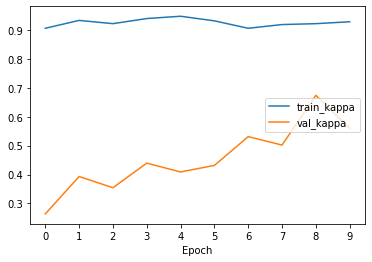

In [ ]:
plt.plot(hist.history['kappa'], label='train_kappa')
plt.plot(hist.history['val_kappa'], label = 'val_kappa')
plt.xlabel('Epoch')
plt.ylabel('')
plt.legend(loc='right')
plt.xticks(np.arange(10))

plt.show()